<a href="https://colab.research.google.com/github/Schwarzam/NN-SPLUS/blob/master/3_bands_87%25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from os.path import isfile, join
import keras
from keras.regularizers import l2, l1
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import load_img, img_to_array, save_img
import matplotlib.image as mpimg
import seaborn as sns
from keras.utils import Sequence, to_categorical

import pandas as pd
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate, GlobalAveragePooling2D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.callbacks import ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Load Files, 
=> create individual folders for each class


In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/trainsets/4_bands_stretch1.3.zip \
    -O /tmp/Noclass_test.zip

--2020-08-12 03:54:55--  https://storage.googleapis.com/trainsets/4_bands_stretch1.3.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 173.194.69.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129829514 (124M) [application/zip]
Saving to: ‘/tmp/Noclass_test.zip’

/tmp/Noclass_test.z 100%[===================>] 123.81M  66.3MB/s    in 1.9s    

2020-08-12 03:54:58 (66.3 MB/s) - ‘/tmp/Noclass_test.zip’ saved [129829514/129829514]



In [4]:
local_zip = '/tmp/Noclass_test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [5]:
base_dir = '/tmp/Galaxies/'
base_dir2 = '/tmp/Galaxies2/'

In [6]:
df = pd.read_csv("/tmp/TestingData.csv", index_col=0)

In [7]:
df['ID1'] = df['ID'].map(lambda ID: os.path.join(base_dir, f'{ID}.png'))
df['ID2'] = df['ID'].map(lambda ID: os.path.join(base_dir2, f'{ID}.png'))

In [8]:
in_channel = 3
img_rows, img_cols = 128, 128
num_classes = 4 # number of appliances

batch_size = 10
epochs = 100
input_shape = (img_rows, img_cols, in_channel)
input_img = Input(shape = input_shape)

### Image Generator 

In [9]:
labels = df['class'].values
arr_labels = df['class'].values

labels = keras.utils.to_categorical(labels, num_classes)

In [10]:
def read_spectograms(file_paths, img_rows, img_cols, channels):
  """
  Reads the spectogram files from disk and normalizes the pixel values
    @params:
      file_paths - Array of file paths to read from
      img_rows - The image height.
      img_cols - The image width.
      as_grey - Read the image as Greyscale or RGB.
      channels - Number of channels.
    @returns:
      The created and compiled model (Model)        
  """
  images = []
  
  for file_path in file_paths:
    images.append(imread(file_path))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / 255.0 #np.max(images)
  
  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images

In [11]:
x_train_IRG = read_spectograms(df['ID1'].values, img_rows, img_cols, in_channel)

x_train_IGU = read_spectograms(df['ID2'].values, img_rows, img_cols, in_channel)

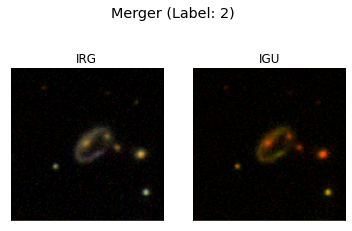

In [12]:
appliances = [
    
    'Elliptical',
    'Lenticular',
    'Merger',
    'Spiral',
    
]

# pick a random index from the list
rn_appliance = np.random.choice(df['class'].values)
rn_label = df['class'].values[rn_appliance]
rn_current = x_train_IRG[rn_appliance]
rn_voltage = x_train_IGU[rn_appliance]

plt.figure()
plt.axis('off')

plt.suptitle(f"{appliances[rn_label]} (Label: {rn_label})", fontsize="x-large")

plt.subplot(121)
curr_img = None

curr_img = np.reshape(rn_current, (img_rows, img_cols, in_channel))

plt.imshow(curr_img, cmap='gray')
plt.title("IRG")
plt.xticks([])
plt.yticks([])

plt.subplot(122)

curr_img = np.reshape(rn_voltage, (img_rows, img_cols, in_channel))

plt.imshow(curr_img, cmap='gray')
plt.title("IGU")
plt.xticks([])
plt.yticks([])
plt.show()

In [13]:
x_train_comp = np.stack((x_train_IRG, x_train_IGU), axis=4)

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, arr_labels, test_size = 0.3, random_state=666)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.33, random_state=666)
val_labels = y_val

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, labels, test_size = 0.3, random_state=666)


# take them apart
train_IRG = x_train[:,:,:,:,0]
test_IRG = x_test[:,:,:,:,0]

train_IGU = x_train[:,:,:,:,1]
test_IGU = x_test[:,:,:,:,1]

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.33, random_state=666)

test_IRG = x_test[:,:,:,:,0]
val_IRG = x_val[:,:,:,:,0]

test_IGU = x_test[:,:,:,:,1]
val_IGU = x_val[:,:,:,:,1]

## Smooth Graphic curves

In [14]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [15]:
hist_arr = []

## **Function to save to Google Drive**

In [16]:
import time
from datetime import date

def mark_progress(history, acc, val_acc, loss, val_loss, lr, ResultData):

  tempo = time.strftime("%H,%M")
  
  hoje = date.today()
  today1 = hoje.strftime("%B %d, %Y")
  today1 = today1.replace(" ", "")

  !mkdir '/content/drive/My Drive/TrainSets/Relatorios/'{today1}
  !mkdir '/content/drive/My Drive/TrainSets/Relatorios/'{today1}'/'{tempo}


  today = [today1 for i in loss]

  epochs = range(1, len(acc)+1)
  lr = [lr for i in loss]

  plot = plot_model(model, to_file=f"/content/drive/My Drive/TrainSets/Relatorios/{today1}/{tempo}/ModelUsed.jpg",
        show_shapes=True,
        show_layer_names=True,
        rankdir="TB",
        dpi=96,)
  
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'r', label='Validation Loss')
  plt.title('Training and validation Loss')
  plt.legend()
  
  plt.savefig(f"/content/drive/My Drive/TrainSets/Relatorios/{today1}/{tempo}/Loss.jpg")
  plt.clf()

  plt.plot(epochs, acc, 'ko', label='Training acc')
  plt.plot(epochs, val_acc, 'k', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  
  plt.savefig(f"/content/drive/My Drive/TrainSets/Relatorios/{today1}/{tempo}/Validation.jpg")
  plt.clf()
  
  ResultData.to_csv(f"/content/drive/My Drive/TrainSets/Relatorios/{today1}/{tempo}/Data.csv")
  model.save(f"/content/drive/My Drive/TrainSets/Relatorios/{today1}/{tempo}/Model")

## Create arrays for append history

In [17]:
def reset_series():
  global acc
  global val_acc
  global val_loss
  global loss
  acc = []
  val_acc = []
  loss = []
  val_loss = []

## Model

In [18]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16

base_model = InceptionV3(weights='imagenet', include_top=False)
base_model1 = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [19]:
def create_convolution_layers(input_img):
  model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = MaxPooling2D((2, 2),padding='same')(model)

  model = Conv2D(128, (3, 3), padding='same')(model)
  model = MaxPooling2D((2, 2),padding='same')(model)

  model = Conv2D(256, (3, 3), padding='same')(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    
  model = Conv2D(512, (3, 3), padding='same')(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)

  return model

In [20]:
# current_input = Input(shape=input_shape)
# current_model = base_model(current_input)
# current_model = GlobalAveragePooling2D()(current_model)

voltage_input = Input(shape=input_shape)

voltage_model = create_convolution_layers(voltage_input)


#conv = concatenate([current_model, voltage_model])

dense = Flatten()(voltage_model)
dense = Dense(1024)(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Dense(256)(dense)

dense = BatchNormalization()(dense)

output = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs= voltage_input, outputs=output)

In [21]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         zoom_range = 0.1,
                         rotation_range = 40)

genX1 = gen.flow(train_IRG, y_train,  batch_size=batch_size,seed=666)

## ------- ##
gen_test = ImageDataGenerator()
genX1_test = gen.flow(test_IRG, y_test,  batch_size=batch_size,seed=666)


## ------- ##
gen_val = ImageDataGenerator()

genX1_val = gen.flow(val_IRG, y_val,  batch_size=batch_size,seed=666)

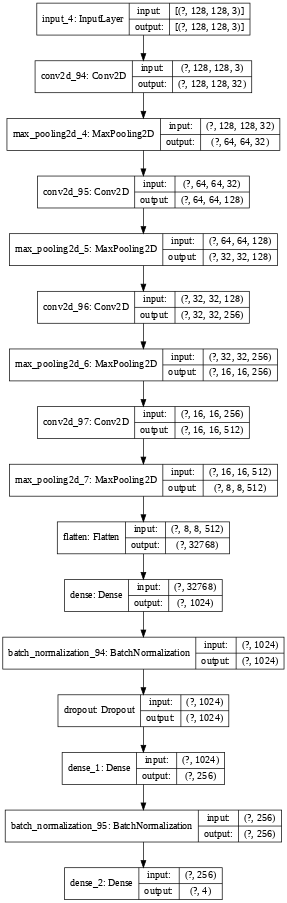

In [22]:
plot_model(model, show_shapes=True,
        show_layer_names=True,
        rankdir="TB",
        dpi=50,)

In [23]:
z = []

In [24]:
model.summary(print_fn=lambda x: z.append(x))

In [27]:
from keras.models import load_model

model = load_model("/content/drive/My Drive/TrainSets/Relatorios/July30,2020/18,08/Model")

## Train model


In [36]:
lr = 1e-9
decay_rate = (lr / 10)
momentum = 0.3

opt = optimizers.SGD(learning_rate=lr, momentum=momentum, decay=decay_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
plot_model(model, show_shapes=True)

In [50]:
history = model.fit(genX1,
                    batch_size=10,
                    epochs=10,
                    steps_per_epoch = len(train_IGU)/batch_size,
                    verbose=1,
                    validation_data=(test_IRG, y_test),
                    shuffle=False)

Epoch 1/10
178/177 [==============================] - 7s 41ms/step - loss: 0.3557 - accuracy: 0.8715 - val_loss: 0.3364 - val_accuracy: 0.8664
Epoch 2/10
178/177 [==============================] - 7s 41ms/step - loss: 0.3446 - accuracy: 0.8755 - val_loss: 0.8149 - val_accuracy: 0.7642
Epoch 3/10
178/177 [==============================] - 7s 40ms/step - loss: 0.3523 - accuracy: 0.8806 - val_loss: 0.6618 - val_accuracy: 0.8035
Epoch 4/10
178/177 [==============================] - 7s 40ms/step - loss: 0.3500 - accuracy: 0.8794 - val_loss: 0.6458 - val_accuracy: 0.8153
Epoch 5/10
178/177 [==============================] - 7s 41ms/step - loss: 0.3430 - accuracy: 0.8761 - val_loss: 0.5608 - val_accuracy: 0.8291
Epoch 6/10
178/177 [==============================] - 7s 41ms/step - loss: 0.3421 - accuracy: 0.8704 - val_loss: 0.5676 - val_accuracy: 0.8291
Epoch 7/10
178/177 [==============================] - 7s 40ms/step - loss: 0.3503 - accuracy: 0.8749 - val_loss: 0.3812 - val_accuracy: 0.8743

In [30]:
hist_arr = np.append(hist_arr, history)

In [31]:
reset_series()

In [51]:
resultado = model.evaluate([val_IRG], y_val)
resultado

8/8 [==============================] - 0s 8ms/step - loss: 0.4482 - accuracy: 0.8770


[0.44818228483200073, 0.8769841194152832]

In [48]:
acc = np.append(acc, history.history['accuracy'])
val_acc = np.append(val_acc,history.history['val_accuracy'])
loss = np.append(loss,history.history['loss'])
val_loss = np.append(val_loss,history.history['val_loss'])

epochs = range(1, len(acc)+1)

Save Model on Drive 

In [49]:
tempo = time.strftime("%H,%M")

hoje = date.today()
today1 = hoje.strftime("%B %d, %Y")
today1 = today1.replace(" ", "")
today = [today1 for i in loss]
lr = [lr for i in loss]

list_of_tuples = list(zip(epochs, lr, acc, val_acc, loss, val_loss, today))

ResultData = pd.DataFrame(list_of_tuples, columns = ['epochs', 'learning_rate','acc', 'val_acc', 'loss', 'val_loss', 'date'])
mark_progress(history,acc, val_acc, loss, val_loss, lr, ResultData)

mkdir: cannot create directory ‘/content/drive/My Drive/TrainSets/Relatorios/August12,2020’: File exists
INFO:tensorflow:Assets written to: /content/drive/My Drive/TrainSets/Relatorios/August12,2020/04,07/Model/assets


<Figure size 432x288 with 0 Axes>

------ // -------

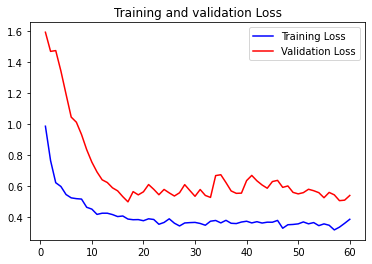

In [41]:
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, smooth_curve(val_loss), 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

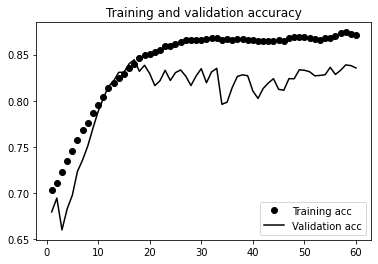

In [42]:
plt.plot(epochs, smooth_curve(acc), 'ko', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

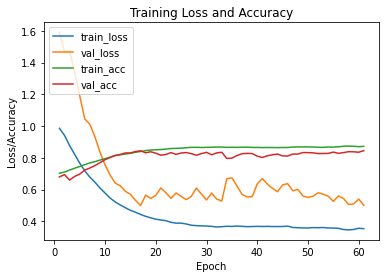

In [52]:
plt.figure()
N = epochs

plt.plot(N, smooth_curve(loss), label="train_loss")
plt.plot(N, smooth_curve(val_loss), label="val_loss")
plt.plot(N, smooth_curve(acc), label="train_acc")
plt.plot(N, smooth_curve(val_acc), label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

## Testing with single image

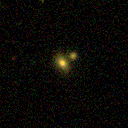

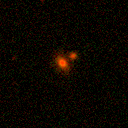

In [53]:
from keras.preprocessing.image import load_img, img_to_array, save_img
from PIL import Image

img_path = '/tmp/Galaxies/SPLUS.STRIPE82-0038.23945.griz.png'

img_path2 = '/tmp/Galaxies2/SPLUS.STRIPE82-0038.23945.griz.png'
#SPLUS.STRIPE82-0029.24730.griz.jpg
image = load_img(img_path, target_size=(128,128))
image2 = load_img(img_path2, target_size=(128,128))

img = img_to_array(image)
img2 = img_to_array(image2)

# img = Image.fromarray(img, 'RGB')
# im_cropped = image.crop((64, 64, 192, 192))
# img = img_to_array(im_cropped)
# img = img.astype('float32') # this line was missing
# img /= 255 #this too

img1 = Image.fromarray(img, 'RGB')
img12 = Image.fromarray(img2, 'RGB')

img = np.expand_dims(img, axis = 0)
img = img.astype('float32') # this line was missing
img /= 255 #this too

img2 = np.expand_dims(img2, axis = 0)
img2 = img2.astype('float32') # this line was missing
img2 /= 255 #this too

display(image)
display(image2)

In [54]:
pred = model.predict(img)
pred

array([[5.5718857e-01, 7.4314157e-05, 4.4141284e-01, 1.3242910e-03]],
      dtype=float32)

In [55]:
# pred = model.predict_classes([img, img2], verbose=1)
pred = np.argmax(pred)

if pred == 0:
    prediction = 'Elliptical'
if pred == 1:
    prediction = 'Lenticular'
if pred == 2:
    prediction = 'Merger'
if pred == 3:
    prediction = 'Spiral'

print(prediction)

Elliptical


## Testing with test_set, confusion matrix


In [56]:
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    x = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    return x

In [57]:
def get_array_labels(array):
  Label_y_pred = []
  for x in array:
    if x == 0:
      Label_y_pred = np.append(Label_y_pred,'Elliptical')
    if x == 1:
      Label_y_pred = np.append(Label_y_pred,'Lenticular')
    if x == 2:
      Label_y_pred = np.append(Label_y_pred,'Merger')
    if x == 3:
      Label_y_pred = np.append(Label_y_pred,'Spiral')
  return Label_y_pred

Normalized confusion matrix


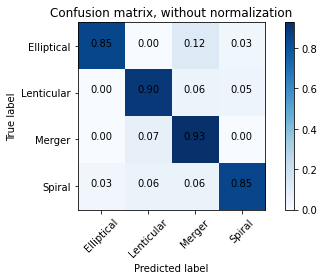

In [58]:
Y_pred = model.predict([val_IRG])
y_pred = np.argmax(Y_pred, axis=1)

y_true = ['Elliptical', 'Lenticular', 'Merger', 'Spiral']
Label_y_pred = get_array_labels(y_pred)
Label_y_true = get_array_labels(val_labels)

cnf_matrix = confusion_matrix(Label_y_pred, Label_y_true, labels=['Elliptical', 'Lenticular', 'Merger', 'Spiral'])

zeta = plot_confusion_matrix(cnf_matrix, classes=['Elliptical', 'Lenticular', 'Merger', 'Spiral'],
                      title='Confusion matrix, without normalization', normalize=True)

target_names = ['Elliptical', 'Lenticular', 'Merger', 'Spiral']
report = classification_report(Label_y_true, Label_y_pred, target_names=target_names)

In [60]:
y_true_labels = [[0,0,0,0]]

for x in val_labels:
  if x == 0:
    y_true_labels = np.append(y_true_labels, [[1, 0, 0, 0]], axis=0)
  if x == 1:
    y_true_labels = np.append(y_true_labels, [[0, 1, 0, 0]], axis=0)
  if x == 2:
    y_true_labels = np.append(y_true_labels, [[0, 0, 1, 0]], axis=0)
  if x == 3:
    y_true_labels = np.append(y_true_labels, [[0, 0, 0, 1]], axis=0)
y_true_labels = y_true_labels[1:]

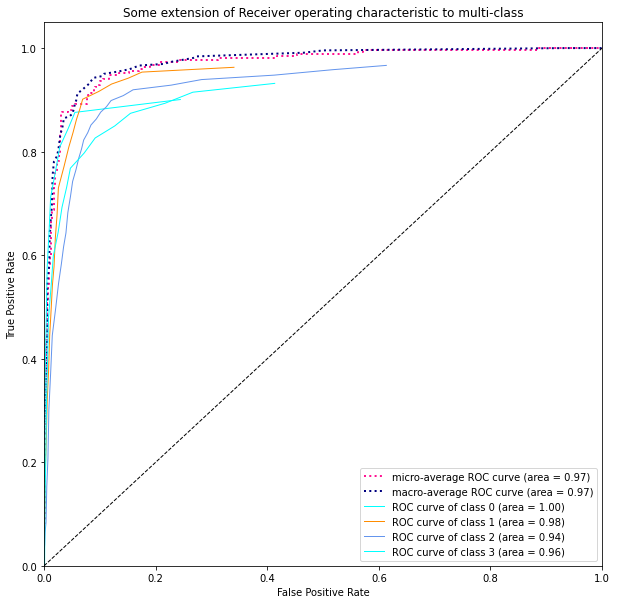

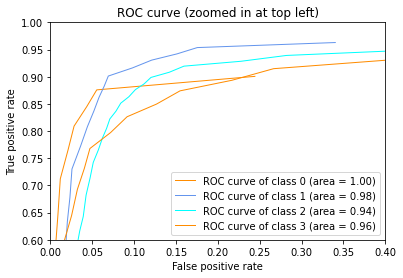

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 1
n_classes = 4

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_labels[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_true_labels.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(smooth_curve(fpr[i]), smooth_curve(tpr[i]), color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

plt.figure(2)
plt.xlim(0, 0.4)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
for i, color in zip(range(n_classes), colors):
    plt.plot(smooth_curve(fpr[i]), smooth_curve(tpr[i]), color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [82]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_labels[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [83]:
fpr = dict()
tpr = dict()
array1 = list(range(0,n_classes))
array2 = list(range(0,n_classes))

roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_labels[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i, color in zip(range(n_classes), colors):    
    array1[i] = fpr[i]
    array2[i] = tpr[i]

newarray1 = list(np.zeros(len(array1)))
for i in range(len(array1)):
  newarray1[i] = f'{list(array1[i])}'

newarray1 = f'{newarray1}'

newarray2 = list(np.zeros(len(array1)))
for i in range(len(array2)):
  newarray2[i] = f'{list(array2[i])}'

newarray2 = f'{newarray1}'

resultado = model.evaluate([val_IRG], y_val)
resultado

8/8 [==============================] - 0s 10ms/step - loss: 0.6216 - accuracy: 0.7976


[0.6215638518333435, 0.7976190447807312]

In [ ]:
pip install schzz --upgrade

  Found existing installation: schzz 0.12
    Uninstalling schzz-0.12:
      Successfully uninstalled schzz-0.12


In [ ]:
fpr = dict()
tpr = dict()
array1 = list(range(0,n_classes))
array2 = list(range(0,n_classes))

roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_labels[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i, color in zip(range(n_classes), colors):    
    array1[i] = fpr[i]
    array2[i] = tpr[i]

newarray1 = list(np.zeros(len(array1)))
for i in range(len(array1)):
  newarray1[i] = f'{list(array1[i])}'

newarray1 = f'{newarray1}'

newarray2 = list(np.zeros(len(array1)))
for i in range(len(array2)):
  newarray2[i] = f'{list(array2[i])}'

newarray2 = f'{newarray1}'

In [63]:
import requests

def make_post(username, password, model_json, acc, val_acc, loss, val_loss, title, evaluate, report):
  data = {'username':username,
            'password':password} 

  x = requests.post(('https://schwarzam.art/api/auth/login'), data=data, json={'Content-Type': 'application/json'}, verify=False)
  
  if x.status_code == 200:
    x = (x.json())
    token = x['token']
    username = x['user']['username']
    email = x['user']['email']

    jsnono = {'Content-Type': 'application/json'}
    headers = {'Authorization' : f'token {token}'}
    
    acc = str(list(np.round(acc, decimals=4)))
    val_acc = str(list(np.round(val_acc, decimals=4)))
    loss = str(list(np.round(loss, decimals=4)))
    val_loss = str(list(np.round(val_loss, decimals=4)))
    evaluate =f'{evaluate}'

    data = {'name': f'{username}',
            'email': f'{email}',
            'title': f'{title}',
            'model_json': model_json,
            'evaluate': evaluate,
            'report': report,
            'acc': (f'{(acc)}'),
            'val_acc': (f'{(val_acc)}'),
            'loss': (f'{(loss)}'),
            'val_loss': (f'{(val_loss)}')}

    response = requests.post('https://schwarzam.art/api/leadsML/', data=data, json=jsnono, headers=headers, verify=False)
    print(response.status_code, 'done')

In [64]:
make_post(##, ##, model.to_json(), acc, val_acc, loss, val_loss, '3 bands IRG - 87', resultado, report)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


b'{"id":55,"name":"gustavoschwarz","title":"3 bands IRG - 87","email":"gustavo.b.schwarz@gmail.com","message":"","owner":null,"created_at":"2020-08-12T04:11:43.723519Z","model_json":"{\\"class_name\\": \\"Sequential\\", \\"config\\": {\\"name\\": \\"sequential_6\\", \\"layers\\": [{\\"class_name\\": \\"InputLayer\\", \\"config\\": {\\"batch_input_shape\\": [null, 128, 128, 3], \\"dtype\\": \\"float32\\", \\"sparse\\": false, \\"ragged\\": false, \\"name\\": \\"conv2d_119_input\\"}}, {\\"class_name\\": \\"Conv2D\\", \\"config\\": {\\"name\\": \\"conv2d_119\\", \\"trainable\\": true, \\"batch_input_shape\\": [null, 128, 128, 3], \\"dtype\\": \\"float32\\", \\"filters\\": 32, \\"kernel_size\\": [3, 3], \\"strides\\": [1, 1], \\"padding\\": \\"valid\\", \\"data_format\\": \\"channels_last\\", \\"dilation_rate\\": [1, 1], \\"groups\\": 1, \\"activation\\": \\"relu\\", \\"use_bias\\": true, \\"kernel_initializer\\": {\\"class_name\\": \\"VarianceScaling\\", \\"config\\": {\\"scale\\": 1.0, \